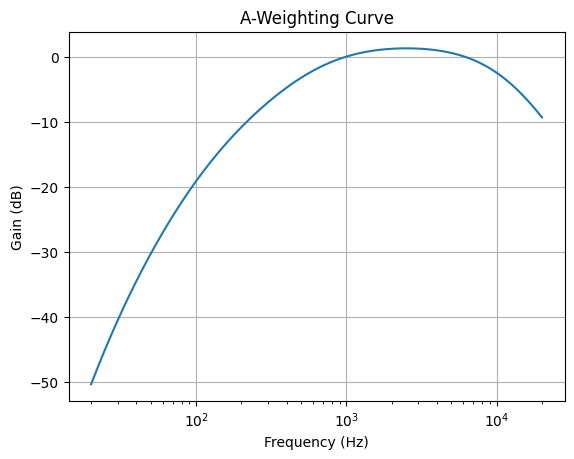

In [1]:
# Cell 1: What is A-weighting?
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Create A-weighting filter
def create_a_weighting(sr=44100):
    # Simplified A-weighting approximation
    # Emphasizes 2-5kHz (where human hearing is most sensitive)
    
    freqs = np.logspace(np.log10(20), np.log10(20000), 1000)
    
    # A-weighting formula (simplified)
    f = freqs
    c1 = 12194**2 * f**4
    c2 = (f**2 + 20.6**2)
    c3 = (f**2 + 107.7**2)
    c4 = (f**2 + 737.9**2)
    c5 = (f**2 + 12194**2)
    
    a_weight = c1 / (c2 * np.sqrt(c3 * c4) * c5)
    a_weight_db = 20 * np.log10(a_weight) + 2.0  # Normalize to 0dB at 1kHz
    
    plt.semilogx(freqs, a_weight_db)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain (dB)')
    plt.title('A-Weighting Curve')
    plt.grid(True)
    plt.show()

create_a_weighting()

In [ ]:
# Cell 2: Play with dasp-pytorch EQ - FIXED VERSION

import torch 
from dasp_pytorch import ParametricEQ

# Create synthetic audio
sr = 44100
duration = 2.0
t = torch.linspace(0, duration, int(sr * duration))
audio = torch.sin(2 * np.pi * 440 * t)
audio = audio.unsqueeze(0).unsqueeze(0)  # [1, 1, samples]

# Create EQ
eq = ParametricEQ(sample_rate=sr)
print(f"EQ needs {eq.num_params} normalized parameters")

# Create normalized parameters (0 to 1 range)
params = torch.rand(1, eq.num_params)  # Random EQ curve

# Apply EQ - use .process_normalized() method
output = eq.process_normalized(audio, params)

print(f"Input shape: {audio.shape}")
print(f"Output shape: {output.shape}")

EQ needs 18 normalized parameters
Input shape: torch.Size([1, 1, 88200])
Output shape: torch.Size([1, 1, 88200])


In [ ]:
import torch
from dasp_pytorch import ParametricEQ

sr = 44100
eq = ParametricEQ(sample_rate=sr)

print("ParametricEQ Structure:")
print(f"  Total parameters: {eq.num_params}")
print(f"  This means: 6 bands × 3 params/band = 18 params")
print(f"  Each band has: [gain, frequency, Q-factor]")
print()

# specific EQ settings
# Format: [band0_gain, band0_freq, band0_q, band1_gain, band1_freq, band1_q, ...]

params = torch.tensor([[
    # Band 0 (low bass ~60Hz)
    0.8,  # gain (0=min, 1=max) - boost
    0.1,  # frequency (0=20Hz, 1=20kHz) - low
    0.5,  # Q factor (0=wide, 1=narrow) - medium
    
    # Band 1 (bass ~200Hz)
    0.6,  # gain - moderate boost
    0.2,  # frequency
    0.5,  # Q
    
    # Band 2 (low-mid ~500Hz)
    0.4,  # gain - slight cut
    0.3,  # frequency
    0.5,  # Q
    
    # Band 3 (mid ~1kHz)
    0.5,  # gain - neutral
    0.5,  # frequency
    0.5,  # Q
    
    # Band 4 (high-mid ~3kHz)
    0.6,  # gain - boost
    0.7,  # frequency
    0.5,  # Q
    
    # Band 5 (treble ~8kHz)
    0.7,  # gain - boost
    0.9,  # frequency - high
    0.5,  # Q
]])

print("Custom EQ curve created!")
print("This boosts bass and treble (a 'smiley' EQ curve)")

ParametricEQ Structure:
  Total parameters: 18
  This means: 6 bands × 3 params/band = 18 params
  Each band has: [gain, frequency, Q-factor]

Custom EQ curve created!
This boosts bass and treble (a 'smiley' EQ curve)


In [11]:
import torch
import numpy as np
from dasp_pytorch import ParametricEQ
from IPython.display import Audio

# Create test audio: sweep from 100Hz to 10kHz
sr = 44100
duration = 3.0
t = torch.linspace(0, duration, int(sr * duration))

# Chirp/sweep signal (better for testing EQ than a single tone)
freq_start = 100
freq_end = 10000
instantaneous_frequency = freq_start + (freq_end - freq_start) * t / duration
phase = 2 * np.pi * torch.cumsum(instantaneous_frequency, dim=0) / sr
audio = torch.sin(phase)
audio = audio.unsqueeze(0).unsqueeze(0) * 0.5  # [1, 1, samples], quieter

eq = ParametricEQ(sample_rate=sr)

# EQ Preset 1: Bass boost
bass_boost = torch.tensor([[0.9, 0.1, 0.5,  # Band 0: boost low
                            0.8, 0.2, 0.5,  # Band 1: boost low
                            0.5, 0.3, 0.5,  # Bands 2-5: neutral
                            0.5, 0.5, 0.5,
                            0.5, 0.7, 0.5,
                            0.5, 0.9, 0.5]])

# EQ Preset 2: Treble boost
treble_boost = torch.tensor([[0.5, 0.1, 0.5,  # Bands 0-3: neutral
                              0.5, 0.2, 0.5,
                              0.5, 0.3, 0.5,
                              0.5, 0.5, 0.5,
                              0.8, 0.7, 0.5,  # Band 4: boost high
                              0.9, 0.9, 0.5]]) # Band 5: boost high

# EQ Preset 3: Midrange cut ("scooped" metal/EDM sound)
mid_cut = torch.tensor([[0.7, 0.1, 0.5,  # Band 0: boost bass
                         0.6, 0.2, 0.5,  # Band 1: boost bass
                         0.3, 0.3, 0.5,  # Band 2: cut low-mid
                         0.2, 0.5, 0.5,  # Band 3: cut mid (strong)
                         0.6, 0.7, 0.5,  # Band 4: boost high
                         0.7, 0.9, 0.5]]) # Band 5: boost treble

# Apply each EQ
out_bass = eq.process_normalized(audio, bass_boost)
out_treble = eq.process_normalized(audio, treble_boost)
out_mid_cut = eq.process_normalized(audio, mid_cut)

print("Listen to these different EQ curves on a frequency sweep:")
print("\n1. Original (no EQ):")
display(Audio(audio.squeeze().numpy(), rate=sr))

print("\n2. Bass Boost:")
display(Audio(out_bass.squeeze().detach().numpy(), rate=sr))

print("\n3. Treble Boost:")
display(Audio(out_treble.squeeze().detach().numpy(), rate=sr))

print("\n4. Mid Cut (scooped):")
display(Audio(out_mid_cut.squeeze().detach().numpy(), rate=sr))

Listen to these different EQ curves on a frequency sweep:

1. Original (no EQ):



2. Bass Boost:



3. Treble Boost:



4. Mid Cut (scooped):


In [ ]:
# Cell 3: Calculate LUFS
import librosa
import pyloudnorm as pyln

# Load any audio file you have (or generate sine wave)
audio = np.random.randn(44100 * 5)  # 5 seconds of noise

# Measure loudness
meter = pyln.Meter(44100)
loudness = meter.integrated_loudness(audio)

print(f"Loudness: {loudness:.2f} LUFS")
print(f"Target for streaming: -14 LUFS")
print(f"This is {-14 - loudness:.2f} dB {'too quiet' if loudness < -14 else 'too loud'}")

In [ ]:
# compare_profiles.py

import torch
import json
from dasp_pytorch import ParametricEQ

# Load your hand-crafted profile
your_warm = torch.tensor([[0.7, 0.1, 0.4, ...]])  # Your version

# Load LLM2Fx prediction
with open('outputs/text2fx/mistral_7b/eq/mix/warm/parameters.json') as f:
    llm_params = json.load(f)
    llm_warm = torch.tensor([[
        llm_params['band0_gain'], llm_params['band0_freq'], ...
    ]])

# Compare
print("Your 'warm' profile:")
print(f"  Sub-bass gain: {your_warm[0,0]:.2f}")
print(f"  Treble gain:   {your_warm[0,15]:.2f}")

print("\nLLM2Fx 'warm' profile (from 150+ engineers):")
print(f"  Sub-bass gain: {llm_warm[0,0]:.2f}")
print(f"  Treble gain:   {llm_warm[0,15]:.2f}")

print("\nReasoning:")
with open('outputs/text2fx/mistral_7b/eq/mix/warm/reasoning.txt') as f:
    print(f.read())

# Apply to test audio
sr = 44100
eq = ParametricEQ(sample_rate=sr)
audio = torch.randn(1, 1, sr)  # Replace with real audio

output_yours = eq.process_normalized(audio, your_warm)
output_llm = eq.process_normalized(audio, llm_warm)

# Listen and decide which sounds better
import IPython.display as ipd
print("\nYour version:")
ipd.display(ipd.Audio(output_yours.squeeze().numpy(), rate=sr))
print("\nLLM2Fx version:")
ipd.display(ipd.Audio(output_llm.squeeze().numpy(), rate=sr))